# Distributed modeling with static schedule
We demonstrate using 2 workers to model 4 shots across Marmousi with a static distribution.

In [44]:
using Distributed, PyPlot, MAT

In [45]:
addprocs(4)

4-element Array{Int64,1}:
 10
 11
 12
 13

In [46]:
@everywhere using DistributedArrays, DistributedJets, Jets, WaveFD, JetPackWaveFD, Random

In [47]:
# SEG SEAM Phase 1, forward modeling for 4 shots. 
file = matopen("SEAM_vp_100x100.mat")
v = read(file, "dataM")
close(file)
dz,dx = 50,50
nz,nx = size(v)
@show dz,dx
@show nz,nx;
v = convert(Array{Float32}, v);

(dz, dx) = (50, 50)
(nz, nx) = (151, 351)


In [48]:
sx = range(0,length=4,stop=(851-1)*20)
nshots = length(sx)
@show nshots;

nshots = 4


## Note on scratch space for temporary files
When dealing with multiple serialized nonlinear wavefields as in this example, we need to specify the location where scratch files will be written.

You may need to change this to point to a temporary directory available on your system.

In [49]:
@everywhere scratch = "scratch"
@assert isdir(scratch)

In [50]:
@everywhere function makeF(i,sx)
    nz,nx,dz,dx = 176,851,20.0,20.0    
    JopNlProp2DAcoIsoDenQ_DEO2_FDTD(;
        b = ones(Float32,nz,nx),
        nthreads = div(Sys.CPU_THREADS,2),
        ntrec = 1601,
        dtrec = 0.004,
        dtmod = 0.002,
        dz = dz,
        dx = dx,
        wavelet = WaveletCausalRicker(f=5.0),
        sx = sx[i],
        sz = dz,
        rx = dx*[0:1:nx-1;],
        rz = 2*dz*ones(length(0:1:nx-1)),
        srcfieldfile = joinpath(scratch, "field-$i.$(randstring()).bin"),
        reportinterval=1000)
end

In [51]:
F = @blockop DArray(I->[makeF(i,sx) for i in I[1], j in I[2]], (nshots,1))

"Jet nonlinear operator, (176, 851) → (5449804,)"

In [52]:
time_beg = time()
d = F*v;

[ Info: nonlinear forward on IG-A23078.local, srcfieldfile=scratch/field-1.JnIxQTwW.bin
[ Info: nonlinear forward on IG-A23078.local, srcfieldfile=scratch/field-4.kb6fwL3J.bin
[ Info: nonlinear forward on IG-A23078.local, srcfieldfile=scratch/field-2.svHn4PrL.bin
[ Info: nonlinear forward on IG-A23078.local, srcfieldfile=scratch/field-3.Ktd9PSGP.bin
[ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step  1000 of  3201   67.15 MCells/s (IO=16.07, EX=22.19, PR=54.86) -- rms d,p; 1.0910e+00 5.9781e-01
[ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step  1000 of  3201   59.98 MCells/s (IO=14.01, EX=18.81, PR=59.91) -- rms d,p; 1.0818e+00 5.4180e-01
[ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step  1000 of  3201   58.10 MCells/s (IO=12.12, EX=18.43, PR=60.70) -- rms d,p; 1.4823e+00 7.5458e-01
[ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step  1000 of  3201   56.35 MCells/s (IO=12.73, EX=19.86, PR=59.27) -- rms d,p; 1.4553e+00 7.8801e-01


In [53]:
time_end = time()
ex_time = (time_end - time_beg)

20.89360499382019

## Plot the shots

In [54]:
# fetch shot gathers from the `DArray` distributed on the workers
shots = [getblock(d, i) for i in 1:nshots];

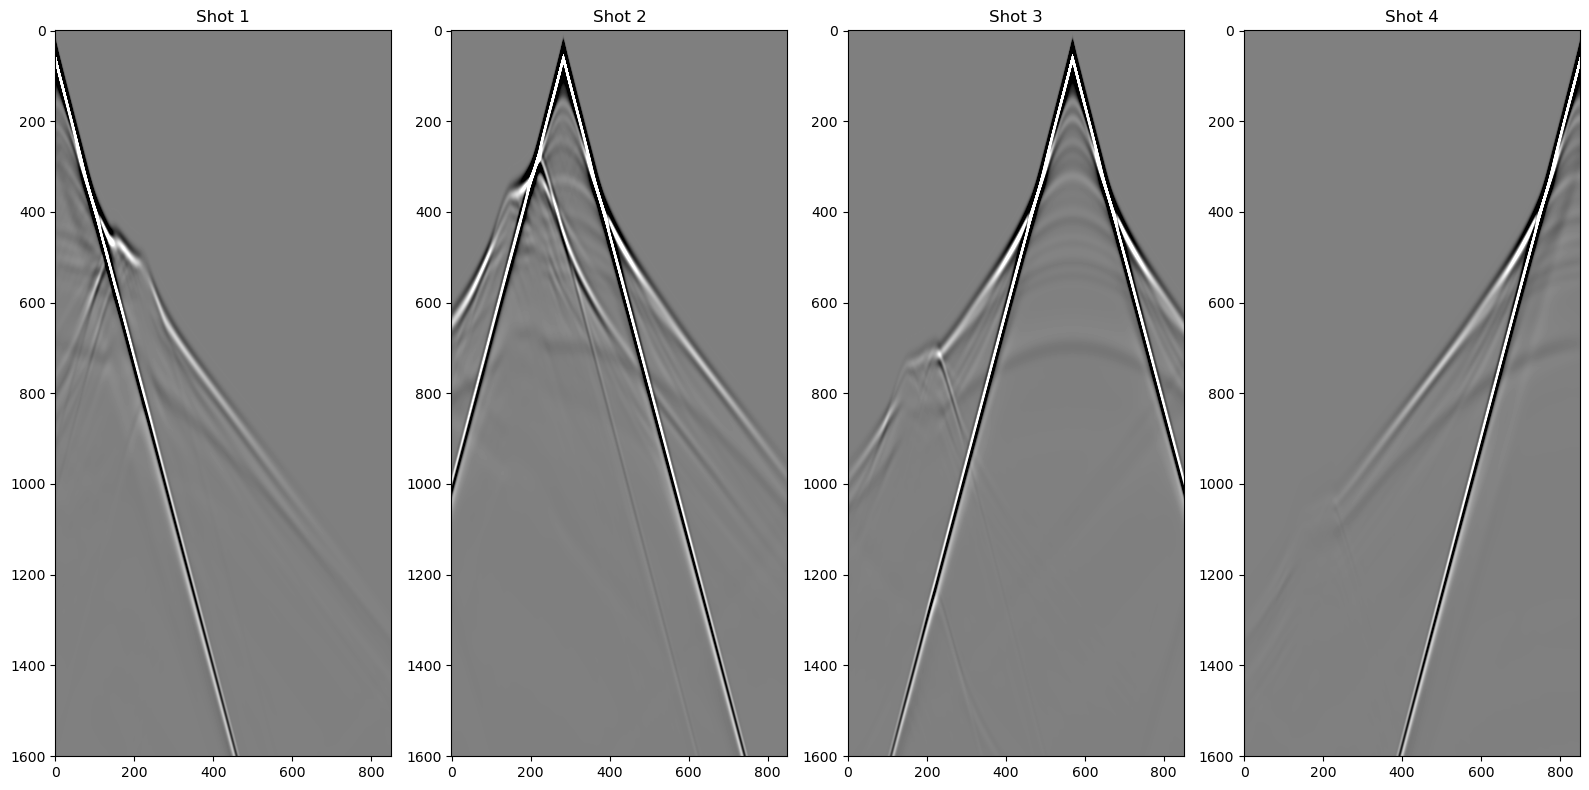

In [55]:
dmax = maximum(abs, extrema(d))
figure(figsize=(16,8)); clf()
for k in 1:nshots
    subplot(1,4,k)
    imshow(shots[k], aspect="auto", cmap="gray")
    clim(0.025 .* [-dmax,+dmax])
    title("Shot $(k)")
end
tight_layout()
nothing

## Remove source field files on local disk

In [56]:
close(F);

## Remove workers

In [57]:
rmprocs(workers());